# MODELS FOR DETECTING CREDIT CARD FRAUD
- **Logistic Regression**
- **Random Forest**
- **KNN**
- **Neural Network**

In [4]:
'''IMPORTS'''

# Data Collection & Pre-processing
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

#Neural Network: MLP Classifier
from sklearn.neural_network import MLPClassifier

# Data Collection and Helper Function 
**file** >> credit_card_fraud.cvs

In [5]:
'''DATA COLLECTION'''
data = pd.read_csv('credit_card_fraud.csv', parse_dates=['trans_date_trans_time',])

X = data.drop(['is_fraud'], axis=1)
Y = data['is_fraud']

In [6]:
'''HELPER FUNCTIONS'''

# Method to calculate the distance between to longitude and latitude points.
# Since we have both the customer (lat, long) at time of purchase and the merchant's (lat,long) we can compute the distance between the two
# this could lead us seeing if the is any correlation between how far a purchase is and if it is fraud or not
def distance(lat1, lon1, lat2, lon2):
    # radius of the Earth in km
    R = 6371.0

    # convert degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # compute the differences between the two points
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # compute the Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    dist = R * c

    return dist

# Pre-processing
- **changing data types** for date of birth
- **adding dimensions** for time of transactions & age
- **one-hot encoding** for abnormal transaction time & jurisdiction 
- **removing dimensions** for unnecessary information 


- **Min-Max Normalization** for age
- **Z-Score Normalization** for AMT and city population

In [7]:
# changing data types
X['dob'] = pd.to_datetime(X['dob'])
print("date of birth changed")

# creating columns out of our original dataset --------------------------

X['hour_of_transaction'] = X.trans_date_trans_time.dt.hour # hour of transaction
X['month_of_transaction'] = X.trans_date_trans_time.dt.month # month of transaction
X['dow_of_transaction'] = X.trans_date_trans_time.dt.day_name() # day of week of transaction
X['cust_age'] = (X['trans_date_trans_time'] - X['dob']).astype('timedelta64[Y]') # age of person during transaction
X['distance_of_transaction'] = X.apply(lambda row: distance(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1) # distance of transaction
print("dimensions added (hour_of_transaction, month_of_transaction, dow_of_transaction, cust_age, distance_of_transaction)")

# encoding: 0 = normal time, 1 = odd time
X['Normal_transaction_time'] = 0
X.loc[X.hour_of_transaction < 5,'Normal_transaction_time'] = 1
X.loc[X.hour_of_transaction > 21,'Normal_transaction_time'] = 1
print("encoded Normal_transaction_time");

# one-hot encoding the categorical features
encoder = OneHotEncoder()
dow_encoded = encoder.fit_transform(X[['dow_of_transaction']])
dow_encoded_df = pd.DataFrame(dow_encoded.toarray(), columns=encoder.categories_[0])
X = pd.concat([X, dow_encoded_df], axis=1)
print("one hot encoding for dow_of_transaction completed")

state_encoded = encoder.fit_transform(X[['state']])
state_encoded_df = pd.DataFrame(state_encoded.toarray(), columns=encoder.categories_[0])
X = pd.concat([X,state_encoded_df], axis=1)
print("one hot encoding for state completed")

merch_encoded = encoder.fit_transform(X[['merchant']])
merch_encoded_df = pd.DataFrame(merch_encoded.toarray(), columns=encoder.categories_[0])
X = pd.concat([X, merch_encoded_df], axis=1)
print("one hot encoding for merchant completed")

cat_encoded = encoder.fit_transform(X[['category']])
cat_encoded_df = pd.DataFrame(cat_encoded.toarray(), columns=encoder.categories_[0])
X = pd.concat([X, cat_encoded_df], axis=1)
print("one hot encoding for category completed")

city_encoded = encoder.fit_transform(X[['city']])
city_encoded_df = pd.DataFrame(city_encoded.toarray(), columns=encoder.categories_[0])
X = pd.concat([X, city_encoded_df], axis=1)
print("one hot encoding for city completed")

# Normalizing the features with varying ranges of numbers ------------------------------------------------------------

# min-max normalization since no real outliers for these features
X['cust_age'] = (X['cust_age'] - X['cust_age'].min()) / (X['cust_age'].max() - X['cust_age'].min())
print("min-max normalization of cust_age completed")

# z-score normalization for values that are wide-spread such as amt and city population
X['amt'] = (X['amt'] - X['amt'].mean()) / X['amt'].std() 
X['city_pop'] = (X['city_pop'] - X['city_pop'].mean()) / X['city_pop'].std()
print("z-score normalization of amt and city_pop completed")

# getting rid of unnecessary columns
X.drop(['trans_num', 'job','trans_date_trans_time', 'state', 'city', 'merchant', 'category', 'dow_of_transaction', 'dob'], axis=1, inplace=True)
print("pre-processing completed")

date of birth changed
dimensions added (hour_of_transaction, month_of_transaction, dow_of_transaction, cust_age, distance_of_transaction)
encoded Normal_transaction_time
one hot encoding for dow_of_transaction completed
one hot encoding for state completed
one hot encoding for merchant completed
one hot encoding for category completed
one hot encoding for city completed
min-max normalization of cust_age completed
z-score normalization of amt and city_pop completed
pre-processing completed


In [5]:
X.head()

,amt,lat,long,city_pop,merch_lat,merch_long,hour_of_transaction,month_of_transaction,cust_age,distance_of_transaction,...,Wales,Wappapello,Weeping Water,Wendel,Westerville,Westfir,Wheaton,Williamsburg,Woods Cross,Yellowstone National Park
0,0.226701,48.8878,-118.2105,-0.365123,49.159047,-118.186462,0,1,0.302632,30.212176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.924891,42.1808,-112.2620,-0.351455,43.150704,-112.154481,0,1,0.513158,108.206083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.159035,41.6125,-122.5258,-0.363621,41.657520,-122.230347,0,1,0.736842,25.059079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.388482,32.9396,-105.8189,-0.362563,32.863258,-106.520205,0,1,0.447368,66.021685,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.394173,43.0172,-111.0292,-0.364024,43.753735,-111.454923,0,1,0.447368,88.830984,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Since this data set is heavely skewed in Non-Fraudulent transactions favor, we have done some research in how to address this.
We concluded that we can take the approach of doing under-sampling, over-sampling, and combining both.

Under-sampling: The number of samples taken from majority class (Not Fraud) will be equal to total number of samples of minority class (Fraud)
Over-sampling: Selecting random samples from the minority class (Fraud) and adding to the training data copies of the sample
---------------------------------------------------------------------------------
---------------------------------------------------

# Logistic Regression Model (Undersampling)

**Hyperparameters**
- **test_size**: The portion of training data used to test against
- **solver**: The solver used to optimize the accuracy of the model
- **penalty**: The norm for determining the penalty of contributive variables
- **C**: The inverse strength for checking penalty

**Tuned Hyperparameters**
- **test_size** = 0.2
- **solver** = 'newton-cg'
- **penalty** = 'l2'
- **C** = 1

Training Data Shape   :  (2851, 914)
Training Labels Shape :  (2851,)
Testing Data Shape    :  (713, 914)
Testing Labels Shape  :  (713,)

Logistic Regression Results with Under-Sampling:

Training Accuracy :  0.9252893721501227
Testing  Accuracy :  0.8835904628330996

Training Set f1 score :  0.9265770423991726
Testing  Set f1 score :  0.8791848617176128

Test set precision :  0.9243466299862448
Test set recall    :  0.9014925373134328


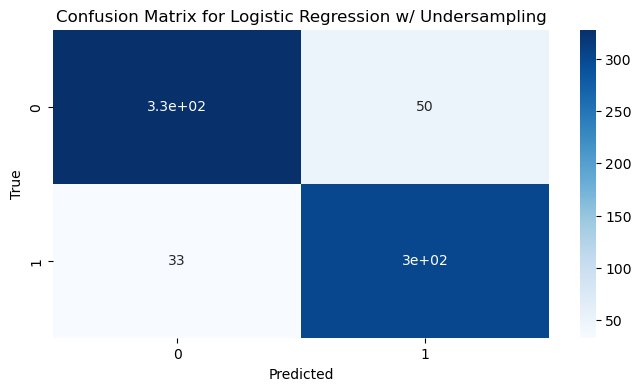

In [8]:
under_sample = RandomUnderSampler()
X_under, Y_under = under_sample.fit_resample(X,Y) # data set used for all under sampled models

X_train_u, X_test_u, Y_train_u, Y_test_u = train_test_split(X_under, Y_under, test_size = 0.2, random_state=42)

print('Training Data Shape   : ', X_train_u.shape)
print('Training Labels Shape : ', Y_train_u.shape)
print('Testing Data Shape    : ', X_test_u.shape)
print('Testing Labels Shape  : ', Y_test_u.shape)
print()

lr_model = LogisticRegression(max_iter=200, solver='newton-cg', penalty='l2', C=1)
lr_model.fit(X_train_u,Y_train_u)

pred_train_lr = lr_model.predict(X_train_u)
pred_test_lr  = lr_model.predict(X_test_u)

print('Logistic Regression Results with Under-Sampling:')
print()
print('Training Accuracy : ', accuracy_score(Y_train_u, pred_train_lr))
print('Testing  Accuracy : ', accuracy_score(Y_test_u, pred_test_lr))

# Checking f1 score, precision and recall
print()
print('Training Set f1 score : ', f1_score(Y_train_u, pred_train_lr))
print('Testing  Set f1 score : ', f1_score(Y_test_u, pred_test_lr))
print()
print('Test set precision : ', precision_score(Y_train_u, pred_train_lr))
print('Test set recall    : ', recall_score(Y_test_u, pred_test_lr))

# showing confusion matrix results
cm = confusion_matrix(Y_test_u, pred_test_lr)

plt.figure(figsize = (8,4), dpi = 100)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.title("Confusion Matrix for Logistic Regression w/ Undersampling")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Random Forest Model (Undersampling)

**Hyperparameters**
- **test_size**: The portion of training data used to test against
- **n_estimators**: The number of decision tress that are "grown" in random forest
- **max_depth**: The maximum depth for each decision tree


**Tuned Hyperparameters**
- **test_size** = 0.26
- **n_estimators** = 150
- **max_depth** = 53

Random Forest Classifier Results with Undersampling:

Training Set Accuracy :  1.0
Testing Set Accuracy  :  0.9449838187702265


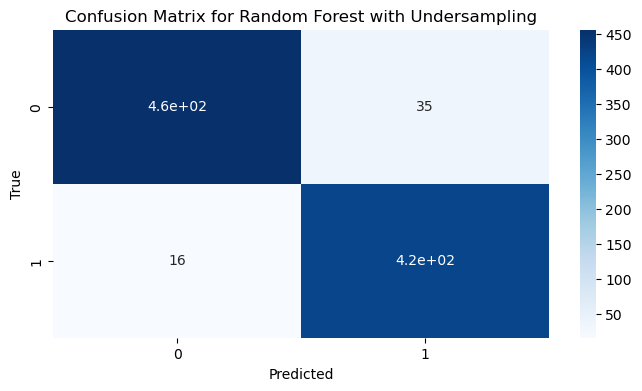

In [9]:
X_train_u, X_test_u, Y_train_u, Y_test_u = train_test_split(X_under, Y_under, test_size = 0.26, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=150, max_depth=53, random_state=42)
rf_classifier.fit(X_train_u, Y_train_u)

pred_train_rf = rf_classifier.predict(X_train_u)
pred_test_rf = rf_classifier.predict(X_test_u)

print('Random Forest Classifier Results with Undersampling:')
print()

print('Training Set Accuracy : ', accuracy_score(Y_train_u, pred_train_rf))
print('Testing Set Accuracy  : ', accuracy_score(Y_test_u, pred_test_rf))

# showing confusion matrix results
cm = confusion_matrix(Y_test_u, pred_test_rf)

plt.figure(figsize = (8,4), dpi = 100)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.title("Confusion Matrix for Random Forest w/ Undersampling")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# KNN Model (Undersampling)
**Hyperparameters**
- **test_size**: The portion of training data used to test against
- **K**: the number of neighbors to compare to a nearby point
- **distance function**: The function used to determine the distance between points
- **number of components**: the number of diemsnions analyzed in total
- **weight**: the method for weighting the importance of neighbors relative to the point

**Tuned Hyperparameters**
- **test size** = 0.2
- **K** = 5
- **distance function** = 'euclidean'
- **number of components** = 10
- **weight** = 'uniform'

In [2]:
#KNN method
def KNN(k, algorithm, distance, weight, x_train, y_train):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm=algorithm, metric=distance, weights=weight)
    knn.fit(x_train, y_train)   

    return knn

#PCA method
def PCA_calc(n, X):
    pca = PCA(n_components=n)
    # Fit the PCA model to the data and transform it   
    X_pca = pca.fit_transform(X)
    X_pca = pd.DataFrame(X_pca)
    
    return X_pca

Accuracy: 0.9943899018232819
Precision: 0.0
Recall: 0.0
F1-score: 0.0


C:\Users\oddco\anaconda3\envs\cs484\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


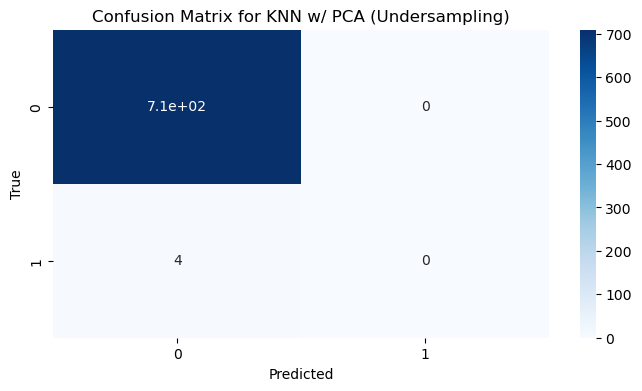

In [10]:
X_pca_10 = PCA_calc(10, X_under)

X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(X_pca_10, Y[:len(X_pca_10)], test_size = 0.2, random_state=42)

knn = KNN(5, 'auto','euclidean', 'uniform', X_train_pca, Y_train_pca)
y_pred = knn.predict(X_test_pca)
acc = accuracy_score(Y_test_pca, y_pred)

print("Accuracy:", accuracy_score(Y_test_pca, y_pred))
print("Precision:", precision_score(Y_test_pca, y_pred))
print("Recall:", recall_score(Y_test_pca, y_pred))
print("F1-score:", f1_score(Y_test_pca, y_pred))

# showing confusion matrix results
cm = confusion_matrix(Y_test_pca, y_pred)

plt.figure(figsize = (8,4), dpi = 100)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.title("Confusion Matrix for KNN w/ PCA (Undersampling)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Neural Network (Undersampling)
**Hyperparameters**
- **test size**: The portion of training data used to test against
- **layers**: The number of neurons used in a layer to make a decision
- **activation function**: the function used to determine the decision in the layer

**Tuned Hyperparameters**
- **test size** = 0.2
- **layers** = (914,500,250,100,50,1)
- **activation function** = 'relu'

Neural Network (MLP) Classifier Results with Undersampling:

Training Set Accuracy :  0.9783845278725825
Testing Set Accuracy  :  0.8694714131607335

Training Set f1 score :  0.9784009094353923
Testing  Set f1 score :  0.8617142857142858

Test set precision :  0.9984532095901005
Test set recall    :  0.8646788990825688


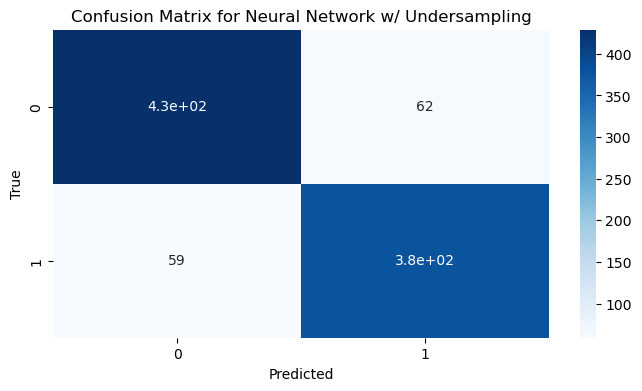

In [16]:
nn_classifier = MLPClassifier(hidden_layer_sizes=(914,500,250,100,50,1), activation='relu', random_state=42)
nn_classifier.fit(X_train_u, Y_train_u)

pred_train_nn = nn_classifier.predict(X_train_u)
pred_test_nn = nn_classifier.predict(X_test_u)

print('Neural Network (MLP) Classifier Results with Undersampling:')
print()

print('Training Set Accuracy : ', accuracy_score(Y_train_u, pred_train_nn))
print('Testing Set Accuracy  : ', accuracy_score(Y_test_u, pred_test_nn))


# Checking f1 score, precision and recall
print()
print('Training Set f1 score : ', f1_score(Y_train_u, pred_train_nn))
print('Testing  Set f1 score : ', f1_score(Y_test_u, pred_test_nn))
print()
print('Test set precision : ', precision_score(Y_train_u, pred_train_nn))
print('Test set recall    : ', recall_score(Y_test_u, pred_test_nn))

# showing confusion matrix results
cm = confusion_matrix(Y_test_u, pred_test_nn)

plt.figure(figsize = (8,4), dpi = 100)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.title("Confusion Matrix for Neural Network w/ Undersampling")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------

# Logistic Regression Model (Oversampling)

**Hyperparameters**
- **test_size**: The portion of training data used to test against
- **solver**: The solver used to optimize the accuracy of the model
- **penalty**: The norm for determining the penalty of contributive variables
- **C**: The inverse strength for checking penalty

**Tuned Hyperparameters**
- **test_size** = 0.06
- **solver** = 'newton-cg'
- **penalty** = 'l2'
- **C** = 1

Training Data Shape   :  (12650, 914)
Training Labels Shape :  (12650,)
Testing Data Shape    :  (808, 914)
Testing Labels Shape  :  (808,)

Logistic Regression Results with Over-Sampling:

Training Accuracy :  0.9969169960474308
Testing  Accuracy :  0.9962871287128713
Training Set f1 score :  0.996921619701634
Testing  Set f1 score :  0.996389891696751

Test set precision :  0.993862134088763
Test set recall    :  1.0


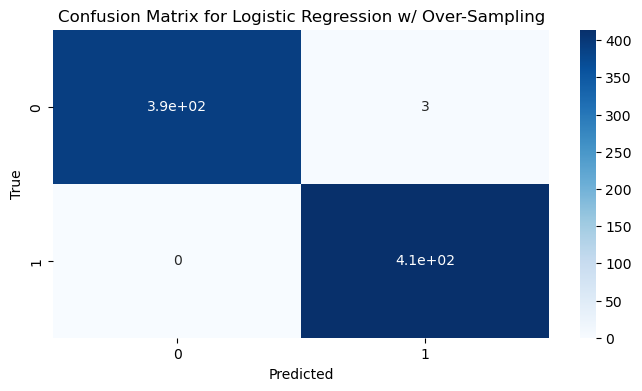

In [14]:
over_sample = RandomOverSampler()
x = X[:(int)(len(X)/50)]
y = Y[:(int)(len(Y)/50)]
X_over, Y_over = over_sample.fit_resample(x,y) # data set used for all over sampled models

X_train_o, X_test_o, Y_train_o, Y_test_o = train_test_split(X_over, Y_over, test_size = 0.06, random_state=42)

print('Training Data Shape   : ', X_train_o.shape)
print('Training Labels Shape : ', Y_train_o.shape)
print('Testing Data Shape    : ', X_test_o.shape)
print('Testing Labels Shape  : ', Y_test_o.shape)
print()

lr_model_over = LogisticRegression(max_iter=200, solver='newton-cg', penalty='l2', C=1)
lr_model_over.fit(X_train_o,Y_train_o)

pred_train_lr2 = lr_model_over.predict(X_train_o)
pred_test_lr2  = lr_model_over.predict(X_test_o)

print('Logistic Regression Results with Over-Sampling:')
print()
print('Training Accuracy : ', accuracy_score(Y_train_o, pred_train_lr2))
print('Testing  Accuracy : ', accuracy_score(Y_test_o, pred_test_lr2))

# Checking f1 score, precision and recall
print('Training Set f1 score : ', f1_score(Y_train_o, pred_train_lr2))
print('Testing  Set f1 score : ', f1_score(Y_test_o, pred_test_lr2))
print()
print('Test set precision : ', precision_score(Y_train_o, pred_train_lr2))
print('Test set recall    : ', recall_score(Y_test_o, pred_test_lr2))

cm = confusion_matrix(Y_test_o, pred_test_lr2)

plt.figure(figsize = (8,4), dpi = 100)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.title("Confusion Matrix for Logistic Regression w/ Overampling")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Random Forest Model (Oversampling)
**Hyperparameters**
- **test_size**: The portion of training data used to test against
- **n_estimators**: The number of decision tress that are "grown" in random forest
- **max_depth**: The maximum depth for each decision tree


**Tuned Hyperparameters**
- **test_size** = 0.06
- **n_estimators** = 100
- **max_depth** = 60

Random Forest Classifier Results with Over-Sampling:

Training Set Accuracy :  1.0
Testing Set Accuracy  :  1.0


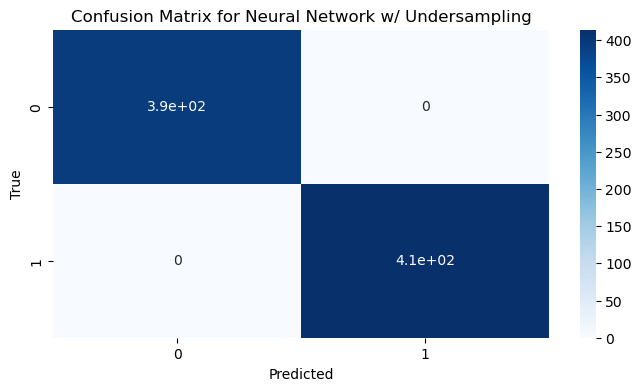

In [21]:
X_train_o, X_test_o, Y_train_o, Y_test_o = train_test_split(X_over, Y_over, test_size = 0.06, random_state=42)

rf_classifier_o = RandomForestClassifier(n_estimators=100, max_depth=60, random_state=42)
rf_classifier_o.fit(X_train_o, Y_train_o)

pred_train_rf2 = rf_classifier_o.predict(X_train_o)
pred_test_rf2 = rf_classifier_o.predict(X_test_o)

print('Random Forest Classifier Results with Over-Sampling:')
print()

print('Training Set Accuracy : ', accuracy_score(Y_train_o, pred_train_rf2))
print('Testing Set Accuracy  : ', accuracy_score(Y_test_o, pred_test_rf2))

# showing confusion matrix results
cm = confusion_matrix(Y_test_o, pred_test_rf2)

plt.figure(figsize = (8,4), dpi = 100)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.title("Confusion Matrix for Neural Network w/ Undersampling")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# KNN Model (Oversampling)
**Hyperparameters**
- **test_size**: The portion of training data used to test against
- **K**: the number of neighbors to compare to a nearby point
- **distance function**: The function used to determine the distance between points
- **number of components**: the number of diemsnions analyzed in total
- **weight**: the method for weighting the importance of neighbors relative to the point

**Tuned Hyperparameters**
- **test size** = 0.2
- **K** = 5
- **distance function** = 'euclidean'
- **number of components** = 10
- **weight** = 'uniform'

Accuracy: 0.986998514115899
Precision: 0.0
Recall: 0.0
F1-score: 0.0


C:\Users\oddco\anaconda3\envs\cs484\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


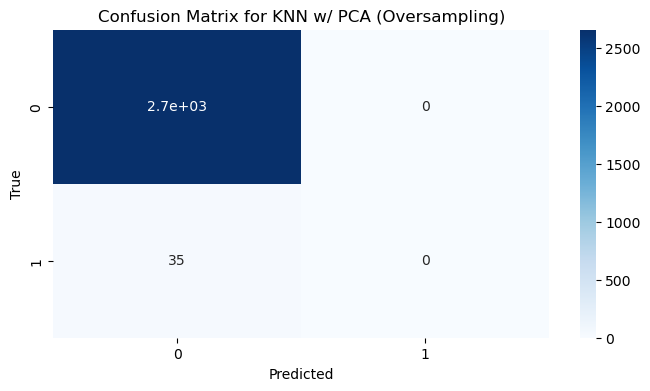

In [15]:
X_pca_10 = PCA_calc(10,X_over)

X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(X_pca_10, Y[:len(X_pca_10)], test_size = 0.2, random_state=42)

knn = KNN(5, 'auto','euclidean', 'uniform', X_train_pca, Y_train_pca)
y_pred = knn.predict(X_test_pca)
acc = accuracy_score(Y_test_pca, y_pred)

print("Accuracy:", accuracy_score(Y_test_pca, y_pred))
print("Precision:", precision_score(Y_test_pca, y_pred))
print("Recall:", recall_score(Y_test_pca, y_pred))
print("F1-score:", f1_score(Y_test_pca, y_pred))

# showing confusion matrix results
cm = confusion_matrix(Y_test_pca, y_pred)

plt.figure(figsize = (8,4), dpi = 100)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.title("Confusion Matrix for KNN w/ PCA (Oversampling)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Neural Network (Oversampling)
**Hyperparameters**
- **test size**: The portion of training data used to test against
- **layers**: The number of neurons used in a layer to make a decision
- **activation function**: the function used to determine the decision in the layer

**Tuned Hyperparameters**
- **test size** = 0.2
- **layers** = (914,500,250,100,50,1)
- **activation function** = 'identity'

In [18]:
def mlp(shape, act_funct, X, Y, X_test, Y_test):
    nn = MLPClassifier(hidden_layer_sizes=shape, activation=act_funct, random_state=42)
    nn.fit(X,Y)

    pred_nn = nn.predict(X_test)

    print('Testing Set Accuracy  : ', accuracy_score(Y_test, pred_nn))
    print('Testing  Set f1 score : ', f1_score(Y_test, pred_nn))
    print()
    print('Test set precision : ', precision_score(Y_test, pred_nn))
    print('Test set recall    : ', recall_score(Y_test, pred_nn))

    cm = confusion_matrix(Y_test, pred_nn)

    plt.figure(figsize = (8,4), dpi = 100)
    sns.heatmap(cm, annot=True, cmap="Blues")
    plt.title("Confusion Matrix for Neural Network w/ Oversampling")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

Testing Set Accuracy  :  0.9987623762376238
Testing  Set f1 score :  0.9987937273823884

Test set precision :  0.9975903614457832
Test set recall    :  1.0


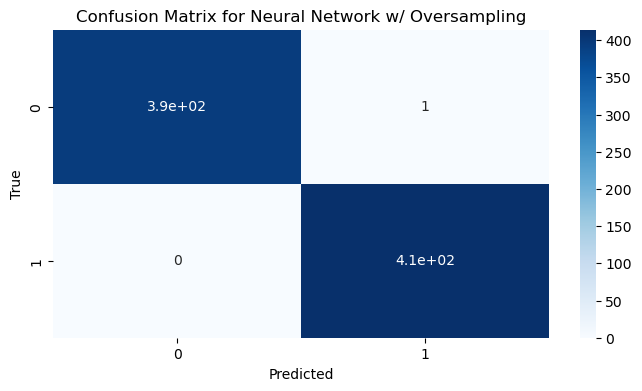

In [19]:
over_sample = RandomOverSampler()
x = X[:(int)(len(X)/50)]
y = Y[:(int)(len(Y)/50)]
X_over, Y_over = over_sample.fit_resample(x,y) # data set used for all over sampled models

X_train_o, X_test_o, Y_train_o, Y_test_o = train_test_split(X_over, Y_over, test_size = 0.06, random_state=42)

mlp((914,500,250,100,50,1), 'identity', X_train_o, Y_train_o, X_test_o, Y_test_o)